In [11]:
import gzip
import os
import shutil
import zipfile
from datetime import timedelta
from pathlib import Path

import igraph as ig
import matplotlib.pyplot as plt
import pandas as pd
import requests
import seaborn as sns
from networkx.drawing.layout import forceatlas2_layout as _forceatlas2_layout
from tqdm import tqdm

# Download the Files

- The files are available at https://snap.stanford.edu/data/higgs-twitter.html

- Base URL: https://snap.stanford.edu/data/higgs-*

| File Name                   | Description                                                                                    |
| --------------------------- | ---------------------------------------------------------------------------------------------- |
| social_network.edgelist.gz  | Friends/follower graph (directed)                                                              |
| retweet_network.edgelist.gz | Graph of who retweets whom (directed and weighted)                                             |
| reply_network.edgelist.gz   | Graph of who replies to who (directed and weighted)                                            |
| mention_network.edgelist.gz | Graph of who mentions whom (directed and weighted)                                             |
| higgs-activity_time.txt.gz  | The dataset provides information about activity on Twitter during the discovery of Higgs boson |


In [ ]:
def download_file(url, dest_folder):
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    local_filename = os.path.join(dest_folder, url.split("/")[-1])
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        total_size = int(r.headers.get("content-length", 0))
        with (
            open(local_filename, "wb") as f,
            tqdm(
                desc=local_filename,
                total=total_size,
                unit="iB",
                unit_scale=True,
                unit_divisor=1024,
            ) as bar,
        ):
            for chunk in r.iter_content(chunk_size=8192):
                f.write(chunk)
                bar.update(len(chunk))
    return local_filename


def unzip_file(zip_path, extract_to):
    if zipfile.is_zipfile(zip_path):
        with zipfile.ZipFile(zip_path, "r") as zip_ref:
            zip_ref.extractall(extract_to)
    elif zip_path.endswith(".gz"):
        with gzip.open(zip_path, "rb") as f_in:
            with open(os.path.splitext(zip_path)[0], "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)


def main():
    base_url = "https://snap.stanford.edu/data/higgs-"
    files = [
        "social_network.edgelist.gz",
        "retweet_network.edgelist.gz",
        "reply_network.edgelist.gz",
        "mention_network.edgelist.gz",
        "activity_time.txt.gz",
    ]
    dest_folder = "higgs_twitter_data"

    for file_name in files:
        url = base_url + file_name
        output_path = Path(dest_folder) / ("higgs-" + file_name.replace(".gz", ""))
        if output_path.exists():
            print(f"{file_name} already exists. Skipping download.")
            continue
        print(f"Downloading {url}...")
        downloaded_file = download_file(url, dest_folder)
        print(f"Unzipping {downloaded_file}...")
        unzip_file(downloaded_file, dest_folder)
        os.remove(downloaded_file)  # Remove the compressed file after extraction
        print(f"Finished processing {file_name}.\n")


main()

higgs_twitter_data/higgs-social_network.edgelist.gz: 100%|██████████| 52.1M/52.1M [00:09<00:00, 5.46MiB/s]


Unzipping higgs_twitter_data/higgs-social_network.edgelist.gz...
Finished processing social_network.edgelist.gz.



higgs_twitter_data/higgs-retweet_network.edgelist.gz: 100%|██████████| 1.87M/1.87M [00:01<00:00, 1.09MiB/s]


Unzipping higgs_twitter_data/higgs-retweet_network.edgelist.gz...
Finished processing retweet_network.edgelist.gz.



higgs_twitter_data/higgs-reply_network.edgelist.gz: 100%|██████████| 198k/198k [00:00<00:00, 405kiB/s] 


Unzipping higgs_twitter_data/higgs-reply_network.edgelist.gz...
Finished processing reply_network.edgelist.gz.



higgs_twitter_data/higgs-mention_network.edgelist.gz: 100%|██████████| 865k/865k [00:01<00:00, 765kiB/s] 


Unzipping higgs_twitter_data/higgs-mention_network.edgelist.gz...
Finished processing mention_network.edgelist.gz.



higgs_twitter_data/higgs-activity_time.txt.gz: 100%|██████████| 3.98M/3.98M [00:02<00:00, 1.75MiB/s]

Unzipping higgs_twitter_data/higgs-activity_time.txt.gz...
Finished processing activity_time.txt.gz.



# Understanding Edge List File Format

- For this exercise, we will only explore the activity_timeline.txt file.
- This file contains four columns: userA userB timestamp interaction type
- every edge is directed from userA to userB

- First let's try to load this file using pandas and explore its contents.


In [5]:
df = pd.read_csv(
    os.path.join("higgs_twitter_data", "higgs-activity_time.txt"),
    sep=" ",
    header=None,
    names=["source", "target", "timestamp", "type"],
)

# Convert timestamp to datetime
df["datetime"] = pd.to_datetime(df["timestamp"], unit="s")

# Get {DT} days before and after the main event date
DT = 1
main_event_date = pd.to_datetime("2012-07-04")
start_date = main_event_date - pd.Timedelta(days=DT)
end_date = main_event_date + pd.Timedelta(days=DT)
df = df[(df["datetime"] >= start_date) & (df["datetime"] <= end_date)]

print(
    "*here the columns type incidates one of RT (retweet), MT (mention) or RE (reply)"
)
df.head(5)

*here the columns type incidates one of RT (retweet), MT (mention) or RE (reply)


,source,target,timestamp,type,datetime
20244,138536,8,1341273611,RT,2012-07-03 00:00:11
20245,7149,7230,1341273617,MT,2012-07-03 00:00:17
20246,7149,7230,1341273617,RE,2012-07-03 00:00:17
20247,155145,8,1341273622,RT,2012-07-03 00:00:22
20248,12824,389,1341273629,MT,2012-07-03 00:00:29


In [6]:
# let's analyze the graph

total_number_of_nodes = df[["source", "target"]].stack().nunique()
total_number_of_edges = len(df)

print(f"Total number of unique nodes: {total_number_of_nodes}")
print(f"Total number of edges: {total_number_of_edges}")

Total number of unique nodes: 216061
Total number of edges: 389890


In [7]:
# let's look at the distribution of interaction types

interaction_counts = df["type"].value_counts()
print("Interaction type distribution:")
print(interaction_counts)

Interaction type distribution:
type
RT    252757
MT    113139
RE     23994
Name: count, dtype: int64


In [8]:
# let's look at the time range of the interactions

min_time = df["datetime"].min()
max_time = df["datetime"].max()
print(f"Time range of interactions: {min_time} to {max_time}")

Time range of interactions: 2012-07-03 00:00:11 to 2012-07-04 23:59:55


In [9]:
# Let's create a network graph using NetworkX
import networkx as nx

G: nx.DiGraph = nx.from_pandas_edgelist(
    df,
    source="source",
    target="target",
    edge_attr=["datetime", "type"],
    create_using=nx.DiGraph,
)

print(f"Graph has {G.number_of_nodes()} nodes and {G.number_of_edges()} edges.")

Graph has 216061 nodes and 323595 edges.


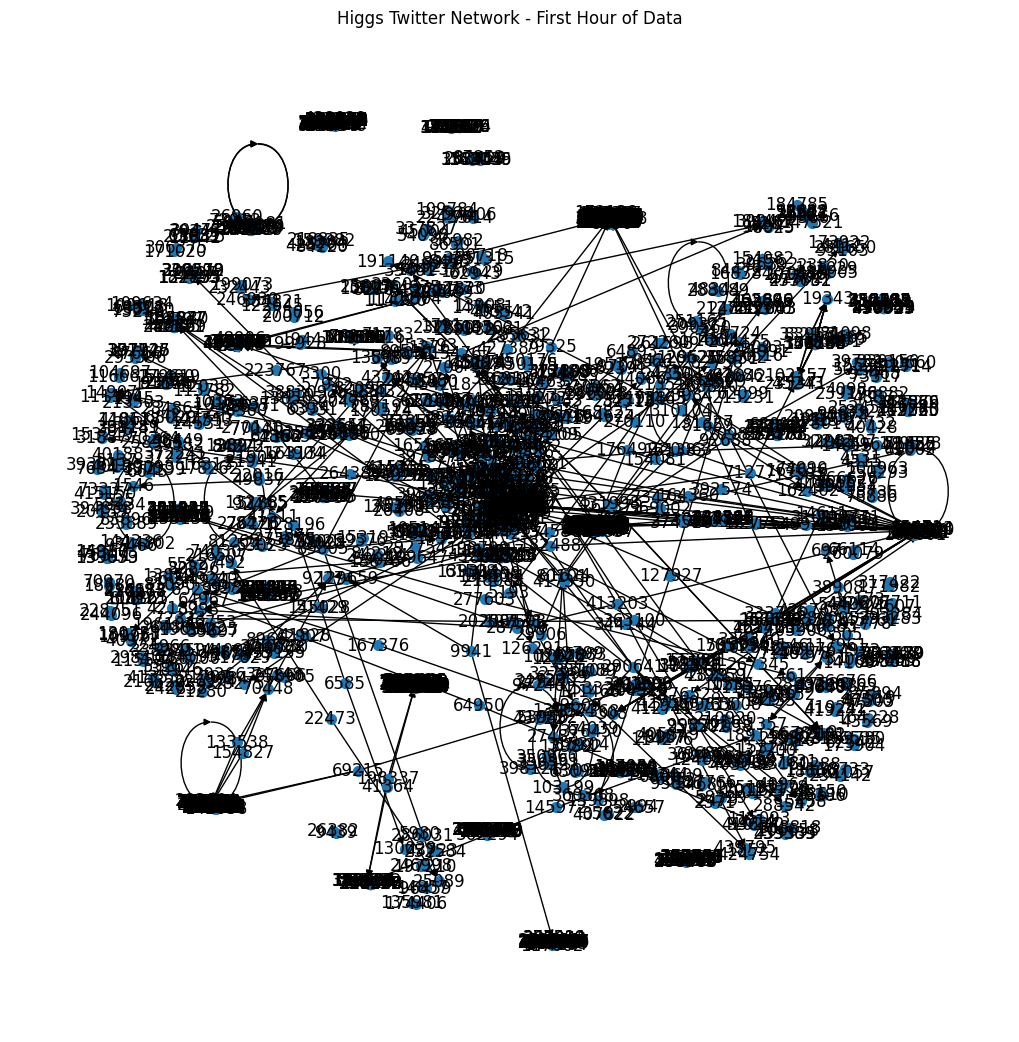

In [10]:
# Let's show the graph with matplotlib for the first hour of data
def forceatlas2_layout(*args, **kwargs) -> dict:
    return _forceatlas2_layout(*args, **kwargs)


first_hour = df[df["datetime"] < (df["datetime"].min() + timedelta(hours=3))]
H: nx.DiGraph = nx.from_pandas_edgelist(
    first_hour,
    source="source",
    target="target",
    edge_attr=["datetime", "type"],
    create_using=nx.DiGraph,
)

plt.figure(figsize=(10, 10))
pos = forceatlas2_layout(
    H,
    max_iter=500,  # default is 100, higher values give more precise layout
    jitter_tolerance=0.5,  # default is 1.0, lower is more precise
    scaling_ratio=3.0,  # default is 2.0, higher values spread out the layout
    gravity=0.5,  # default is 1.0, higher values pull nodes towards the center
)
nx.draw(H, pos, with_labels=True, node_size=50, font_size=12)
plt.title("Higgs Twitter Network - First Hour of Data")
plt.show()

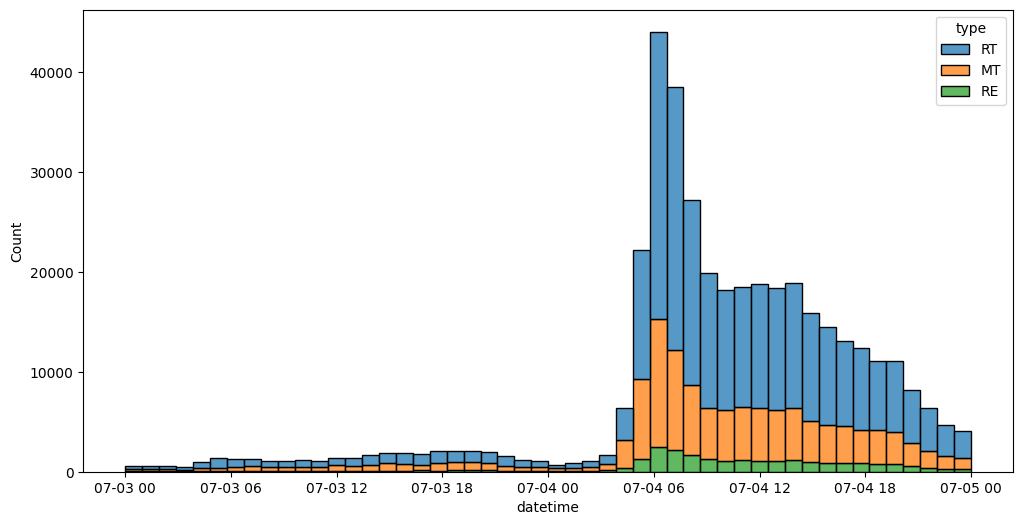

In [12]:
# Visualise early diffusion: e.g., plot number of new retweeters over time.
plt.figure(figsize=(12, 6))

sns.histplot(
    df,
    x="datetime",
    bins=50,
    kde=False,
    hue="type",
    multiple="stack",
)

plt.show()


In [ ]:
# Compute degree
degree_dict = dict(G.degree())
nx.set_node_attributes(G, degree_dict, "degree")

In [13]:
# Compute betweenness centrality

# print("Computing betweenness centrality...")
# centrality_dict = nx.betweenness_centrality(G)
# nx.set_node_attributes(G, centrality_dict, "betweenness_centrality")
G_ig = ig.Graph.from_networkx(G)

# compute betweenness centrality for all vertices
vertex_betweenness = G_ig.betweenness()

# put it back to networkx graph
betweenness_dict = {v.index: vertex_betweenness[v.index] for v in G_ig.vs}
nx.set_node_attributes(G, betweenness_dict, "betweenness_centrality")

In [14]:
# plot betweenness centrality in network
plt.figure(figsize=(10, 10))
pos = forceatlas2_layout(
    G,
    max_iter=500,
    jitter_tolerance=0.5,
    scaling_ratio=3.0,
    gravity=0.5,
)
node_sizes = [100 + 5000 * G.nodes[n]["betweenness_centrality"] for n in G.nodes()]
nx.draw(G, pos, with_labels=False, node_size=node_sizes, font_size=8)
plt.title("Higgs Twitter Network - Betweenness Centrality")
plt.show()

: 

In [ ]:
# Compute clustering coefficient
clustering_dict = nx.clustering(G.to_undirected())
nx.set_node_attributes(G, clustering_dict, "clustering_coefficient")

In [ ]:
# Compute modularity classes using the Louvain method
import community as community_louvain

# Add modularity class using the Louvain method
partition = community_louvain.best_partition(G.to_undirected())
nx.set_node_attributes(G, partition, "modularity_class")

In [ ]:
# Create a DataFrame for analysis
node_metrics = pd.DataFrame.from_dict(
    {
        node: {
            "degree": G.nodes[node]["degree"],
            "betweenness_centrality": G.nodes[node]["betweenness_centrality"],
            "clustering_coefficient": G.nodes[node]["clustering_coefficient"],
        }
        for node in G.nodes()
    },
    orient="index",
)
print(node_metrics.head())